In [13]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import time

In [14]:
global QUIET, MAX_ITER, ABSTOL, RELTOL
QUIET = False
MAX_ITER = 1000
ABSTOL = 1e-4
RELTOL = 1e-2 

In [15]:
m, n = 100, 200
p = 20 / n
group_number = 5
x0 = sci.sparse.rand(n*group_number, 1, p).toarray() # n x 1 array with p% non-zeros
A_grouped = np.random.randn(m, n*group_number)
A_grouped = A_grouped*sci.sparse.diags([1/np.sqrt(np.sum(A_grouped**2, axis=0))], [0]) # normalize columns

b_grouped_list = []
for i in range(group_number):
    b_grouped_list.append(A_grouped[:,i*n:(i+1)*n] @ x0[i*n:(i+1)*n])
b_grouped = np.concatenate(b_grouped_list, axis=1)

# pentalty parameter and l1 soft thresholding
rho, alpha = 1.0, 1.0

In [16]:
def soft_threshold(x, lamb):
    return np.maximum(0, np.abs(x) - lamb) * np.sign(x)

def objective_f(x_grp, A_grp, b_grp, group_number):
    sum = 0
    for ind_x in range(group_number):
        sum = sum + 0.5 * np.linalg.norm(A_grp[:,ind_x*n:(ind_x+1)*n] @ x_grp[:, ind_x] - b_grp[:,ind_x])**2
    return sum

In [17]:
# Data processing
# Compute At_i*b_i for each group
Atb_grouped_list = []
for i in range(group_number):
    Atb_grouped_list.append(A_grouped[:,i*n:(i+1)*n].T @ b_grouped[:,i])

## ADMM Solver

In [20]:
x = np.zeros((n, group_number)) # reshape x0 to a matrix to simplifiy calculation
z = np.zeros((n, 1))
u = np.zeros((n, group_number))  # u is the dual variable

history = {'objval': [], 'r_norm': [], 's_norm': [], 'eps_pri': [], 'eps_dual': []}

time_start = time.time()
# ADMM solver
for k in range(MAX_ITER):
    # x-update
    for ind_x in range(group_number):
        u_local = u[:, ind_x].reshape(-1, 1)
        q_local = Atb_grouped_list[ind_x].reshape(-1, 1) + rho * (z - u_local)
        x_local = sci.linalg.solve(
            A_grouped[:, ind_x * n : (ind_x + 1) * n].T
            @ A_grouped[:, ind_x * n : (ind_x + 1) * n]
            + rho * np.eye(n),
            q_local,
        )
        x[:, ind_x] = x_local.ravel()

    # z-update without relaxation
    z_old = z
    z = np.average(x + u / rho, axis=1).reshape(-1, 1)

    # u-update
    for ind_u in range(group_number):
        u_local = u[:, ind_u].reshape(-1, 1)
        u[:, ind_u] = (u_local + rho * (x[:, ind_u].reshape(-1, 1) - z)).ravel()
        
    # diagnostics, reporting, termination checks
    # objective values: residual & target function value & dual variable convergence
    history['objval'] = np.append(history['objval'], objective_f(x, A_grouped, b_grouped, group_number))
    history['r_norm'] = np.append(history['r_norm'], np.linalg.norm(x - z))
    history['s_norm'] = np.append(history['s_norm'], np.linalg.norm(-rho * (z - z_old)))
    history['eps_pri'] = np.append(history['eps_pri'], np.sqrt(n) * ABSTOL + RELTOL * max(np.linalg.norm(x), np.linalg.norm(-z)))
    history['eps_dual'] = np.append(history['eps_dual'], np.sqrt(n) * ABSTOL + RELTOL * np.linalg.norm(rho * u))
    
    # history reporting
    if not QUIET:
        print('iter: %d, objval: %f, r_norm: %f, s_norm: %f' % (k, history['objval'][k], history['r_norm'][k], history['s_norm'][k]))
    
    # termination checks
    if history['r_norm'][k] < history['eps_pri'][k] and history['s_norm'][k] < history['eps_dual'][k]:
        break

time_end = time.time()
print('Optimization finished. Elapsed time: %f' % (time_end - time_start))

iter: 0, objval: 1.830886, r_norm: 2.205150, s_norm: 0.525828
iter: 1, objval: 3.393019, r_norm: 1.272106, s_norm: 0.502758
iter: 2, objval: 4.472887, r_norm: 0.887168, s_norm: 0.387414
iter: 3, objval: 5.278560, r_norm: 0.666071, s_norm: 0.287125
iter: 4, objval: 5.883092, r_norm: 0.510058, s_norm: 0.216265
iter: 5, objval: 6.332881, r_norm: 0.394024, s_norm: 0.166842
iter: 6, objval: 6.666673, r_norm: 0.307093, s_norm: 0.130660
iter: 7, objval: 6.914912, r_norm: 0.241288, s_norm: 0.103096
iter: 8, objval: 7.099988, r_norm: 0.190755, s_norm: 0.081682
iter: 9, objval: 7.238049, r_norm: 0.151532, s_norm: 0.064835
iter: 10, objval: 7.340872, r_norm: 0.120897, s_norm: 0.051416
iter: 11, objval: 7.417207, r_norm: 0.096825, s_norm: 0.040626
iter: 12, objval: 7.473648, r_norm: 0.077738, s_norm: 0.031933
iter: 13, objval: 7.515193, r_norm: 0.062435, s_norm: 0.024975
iter: 14, objval: 7.545642, r_norm: 0.050040, s_norm: 0.019472
iter: 15, objval: 7.567870, r_norm: 0.039945, s_norm: 0.015178
Op

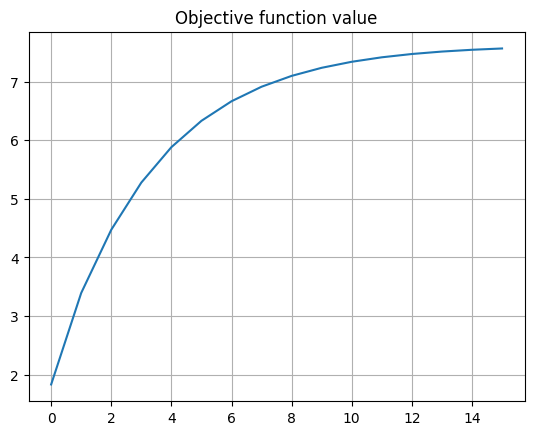

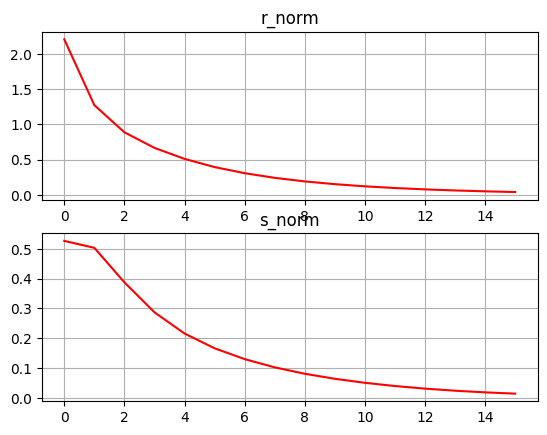

In [21]:
LEN = np.size(history['objval'])
plt.figure()
plt.plot(range(LEN), history['objval'], label='Objective function value')
plt.title('Objective function value')
plt.grid()
plt.show()

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(range(LEN), history['r_norm'], label='r_norm', color='r')
plt.title('r_norm')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(range(LEN), history['s_norm'], label='s_norm', color='r')
plt.title('s_norm')
plt.grid()
plt.show()